# Лабораторная работа №3

## Описание и оценка датасета

В работе воспользуемся датасетом со статистикой игроков EPL сезона 2020-21


* Position: Каждый игрок занимает определённую позицию, на которой он регулярно играет. Позиции в этом наборе данных: FW - Нападающий, MF - Полузащитник, DF - Защитник, GK - Вратарь.
* Starts: Количество раз, когда игрок был включён в стартовый состав из 11 игроков тренером.
* Mins: Количество минут, сыгранных игроком.
* Goals: Количество голов, забитых игроком.
* Assists: Количество раз, когда игрок ассистировал другому игроку в забивании гола.
* Passes_Attempted: Количество передач, сделанных игроком.
* Perc_Passes_Completed: Количество передач, которые игрок точно отдал своему партнёру по команде.

* xG:Ожидаемое количество голов от игрока в матче..
* xA:Ожидаемое количество ассистов от игрока в матче..
* Yellow_Cards:Игроки получают жёлтую карточку от судьи за недисциплину, технические фолы или другие мелкие нарушения..
* Red Cards:Игроки получают красную карточку за накопление 2 жёлтых карточек в одном матче или за серьёзный фол..

## Метка классификации

В качестве целевой метки выступит атрибут Position, т.е. мы будем классифицировать игроков по их позиции, опираясь на из игровую статистику.

FW - Нападающий
MF - Полузащитник
DF - Защитник
GK - Вратарь

## Анализ данных

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn

In [24]:
data = pd.read_csv("../dataset/EPL_20_21.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   532 non-null    object 
 1   Club                   532 non-null    object 
 2   Nationality            532 non-null    object 
 3   Position               532 non-null    object 
 4   Age                    532 non-null    int64  
 5   Matches                532 non-null    int64  
 6   Starts                 532 non-null    int64  
 7   Mins                   532 non-null    int64  
 8   Goals                  532 non-null    int64  
 9   Assists                532 non-null    int64  
 10  Passes_Attempted       532 non-null    int64  
 11  Perc_Passes_Completed  532 non-null    float64
 12  Penalty_Goals          532 non-null    int64  
 13  Penalty_Attempted      532 non-null    int64  
 14  xG                     532 non-null    float64
 15  xA    

Избавимся от записей с пустыми полями

In [25]:
data = data.dropna()

Посмотрим сколько уникальных меток существует в датасете

In [26]:
data['Position'].value_counts(normalize=True)

Position
DF       0.334586
MF       0.203008
FW       0.152256
FW,MF    0.088346
GK       0.078947
MF,FW    0.067669
DF,MF    0.028195
MF,DF    0.024436
FW,DF    0.011278
DF,FW    0.011278
Name: proportion, dtype: float64

Классы потеряли баланс из-за совмещения некотороми игроками нескольких позиций, но всё же возьмём для классификации эту метку

## Классификация


Поделим данные на тренировочные и тестовые

In [27]:
stat_columns = [col for col in data if col != 'Position' and col != 'Name' and col != 'Club' and col != 'Nationality']

X = data[stat_columns]
Y = data['Position']

Конвертируем элементы атрибута Position и стандартизируем данные.


In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [29]:
from sklearn.model_selection import train_test_split

X_tr, X_t, Y_tr, Y_t = train_test_split(X, Y, stratify=Y)


# kNN

Найдем оптимальный параметр k для kNN при помощи GridSearch

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# будем перебирать число соседей от 1 до 30
grid_params = {'n_neighbors': [i for i in range(1, 30+1)],
               'weights': ['uniform', 'distance'],
               'metric': ['minkowski', 'euclidean', 'manhattan']
              }

# ищем K
gs = GridSearchCV(knn, grid_params, scoring='accuracy', refit=True)

g_res = gs.fit(X_tr, Y_tr)

# лучшие параметры
k = g_res.best_params_['n_neighbors']
metric = g_res.best_params_['metric']
weights = g_res.best_params_['weights']

g_res.best_params_

C:\Users\kaban\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'uniform'}

Лучшие параметры для kNN приведены выше. Теперь, пользуясь этими значениями, проведем kNN-классификацию.

In [31]:
knn = KNeighborsClassifier(n_neighbors=k, weights=weights).fit(X_tr, Y_tr)
# запускаем классификацию на тестовой выборке
predicted = knn.predict(X_t)

## Оценка качества классификации

Accuary оценка качества классификации:

In [32]:
right = 0
wrong = 0

for i, ubc in enumerate(Y_t):
    if predicted[i] == ubc:
        right += 1
    else:
        wrong += 1
        
accuracy = right / (right + wrong)
print(accuracy)

0.518796992481203


C:\Users\kaban\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


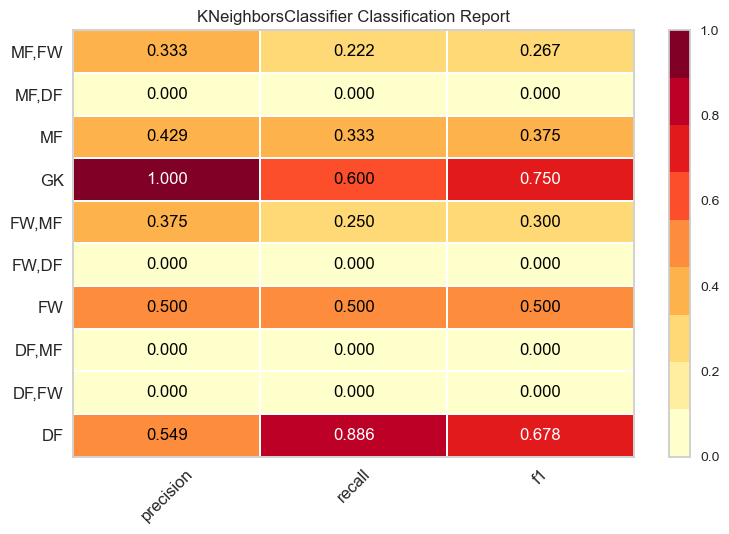

In [33]:
from yellowbrick.classifier import ClassificationReport

report = ClassificationReport(knn, classes=encoder.classes_)
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

ROC оценка качества:

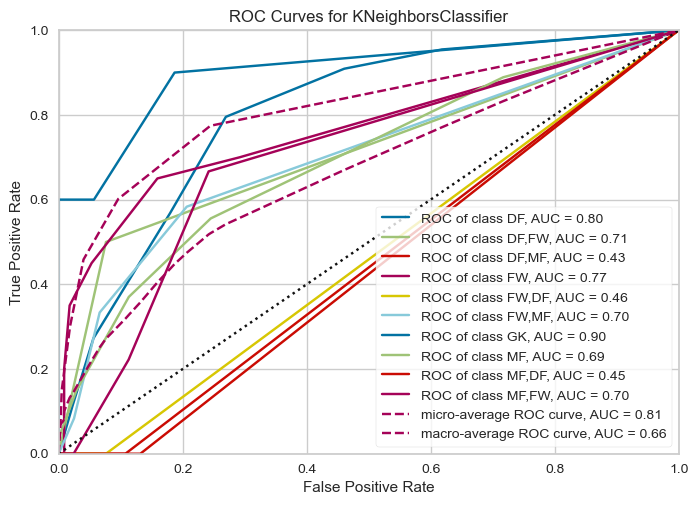

In [34]:
from yellowbrick.classifier import ROCAUC

report = ROCAUC(knn, classes=encoder.classes_)
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

## Дерево решений

Проводим классификацию:

In [35]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_tr, Y_tr)

predicted = dtc.predict(X_t)

## Accuracy оценка качества классификации

In [36]:
right = 0
wrong = 0

for i, pos in enumerate(Y_t):
    if predicted[i] == pos:
        right += 1
    else:
        wrong += 1
        
accuracy = right / (right + wrong)
print(accuracy)

0.45112781954887216


## Precision, Recall, F1 оценки качества классификации

C:\Users\kaban\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


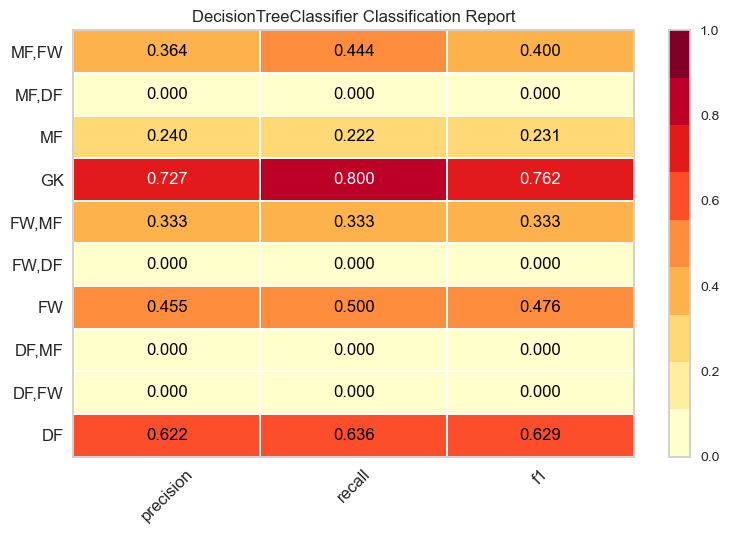

In [37]:
report = ClassificationReport(dtc, classes=encoder.classes_)
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

## ROC оценка качества классификации

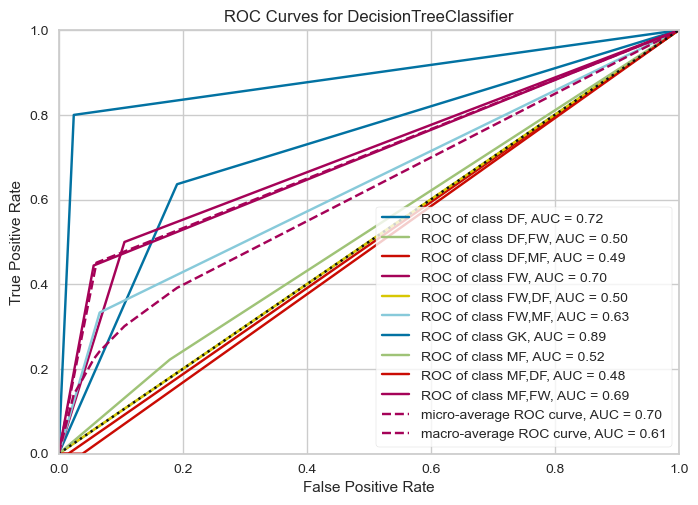

In [38]:
report = ROCAUC(dtc, classes=encoder.classes_)
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

## Анализ классификации

Приходим к выводу, что классификация прошла наполовину успешно. Заметим, что модели легко удаётся распознать игроков на позициях GK (вратарь) и DF (защитник), это вполне очевидно, потому что игроки на этих позициях, как правило, имеют уникальную статистику, отличную от остальных амплуа и не отличающуюся большим количеством голов и ассистов. Тяжелее всего модели определить игроков, игравших на нескольких позициях за один сезон. Причину этого тоже можно определить: игроки на смежных позициях, как правило, статистически не выделяются и отыгрывают по-разному от игры к игре. В это же время модели неплохо удалось распознать FW позицию (нападающие) - эти игроки, как раз выделяются самой высокой результативностью.